# Read and Preprocess data

## import and functions

In [5]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
from TrackSelectorDNN.data_manager.dataset import TrackDatasetFromFile
from trackkit import preprocessing as pre
from trackkit import plotting as plot
from trackkit import summary as summ

In [3]:
!ls /shared/data

02d2a15e-2847-414f-bf92-110da4d8577f.root
05cab870-a0f4-45ee-bb6a-3903e36633c4.root
07c33aa0-e7ba-464a-b756-6dddef0d01f9.root
089387a1-f49f-44a6-8c97-475ae005b186.root
0dc95230-cf9c-4615-ac3f-daca7baa3bc0.root
1000_tracks_dataset.root
1000_tracks_skip-connections_with-2-3-pair_dataset.root
100_tracks_no-skip-connections_dataset.root
100_tracks_skip-connections_dataset.root
100_tracks_train_dataset.root
100_tracks_with-skip-connections_dataset.root
100_tracks_with-skip-connections_no-2-3_dataset.root
1151f09c-ca6a-4d33-9547-fda44c69e533.root
1342be18-5493-4a8f-8bac-026001b7dfe0.root
172f36e5-a215-45a6-9cfe-e413d1290711.root
17b5f041-7578-4195-9cfb-52785883d77c.root
1837dda8-1b7e-4218-ae35-f6190de8551e.root


In [4]:
#INPUT_PATH = "ext.root"
INPUT_PATH  = "/shared/data/100_tracks_skip-connections_dataset.root"
OUTPUT_PATH = "none" #/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_train-val_dataset_skip-connections.pt"
OUTPUT_PATH_TRAIN = "none" #/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_train_dataset_skip-connections.pt"
OUTPUT_PATH_VAL  = "none" #/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_val_dataset_skip-connections.pt"
MAX_HITS = 16

LOW_PERCENTILE  = 0.001
HIGH_PERCENTILE = 0.999
EPSILON = 1.e-8

## Read data from file

In [6]:
# Open the ROOT file
file = uproot.open(INPUT_PATH)
print(file.keys())

print("")
print("-----------------------------------------------")
print("-----------------------------------------------")
print("")

# Access the Events TTree
events = file["Events"]

# List branches in Events
print("Branches in Events:")

for branch in events.keys():
# Inspect first few entries
    print("   -", branch)

# Read all branches into an awkward array
data = events.arrays(library="ak")

['Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']

-----------------------------------------------
-----------------------------------------------

Branches in Events:
   - run
   - luminosityBlock
   - event
   - bunchCrossing
   - orbitNumber
   - nGenJet
   - GenJet_eta
   - GenJet_mass
   - GenJet_phi
   - GenJet_pt
   - nGenPart
   - GenPart_genPartIdxMother
   - GenPart_statusFlags
   - GenPart_pdgId
   - GenPart_status
   - GenPart_eta
   - GenPart_mass
   - GenPart_phi
   - GenPart_pt
   - nhltPixelTrackRecHits
   - hltPixelTrackRecHits_globalX
   - hltPixelTrackRecHits_globalY
   - hltPixelTrackRecHits_globalZ
   - hltPixelTrackRecHits_globalErrX
   - hltPixelTrackRecHits_globalErrY
   - hltPixelTrackRecHits_globalErrZ
   - hltPixelTrackRecHits_globalR
   - hltPixelTrackRecHits_globalEta
   - hltPixelTrackRecHits_globalPhi
   - nhltPixelTrack
   - hltPixelTrack_isHighPurity
   - hltPixelTrack_isTight
   - hltPixelTrack_duplicate
   - hltPixelTrack_m

Decide which branches contain either input features or output labels

In [7]:
recHitBranches = [
    "hltPixelTrackRecHits_globalX",
    "hltPixelTrackRecHits_globalY",
    "hltPixelTrackRecHits_globalZ",
    "hltPixelTrackRecHits_globalErrX",
    "hltPixelTrackRecHits_globalErrY",
    "hltPixelTrackRecHits_globalErrZ",
    "hltPixelTrackRecHits_globalR",
    "hltPixelTrackRecHits_globalEta",
    "hltPixelTrackRecHits_globalPhi"
]

recoPixelTrackBranches = [
    "hltPixelTrack_matched",
    "hltPixelTrack_isHighPurity",
    "hltPixelTrack_nPixelHits",
    "hltPixelTrack_nTrkLays",
    "hltPixelTrack_charge",
    "hltPixelTrack_chi2",
    "hltPixelTrack_dXY",
    "hltPixelTrack_dZ",
    "hltPixelTrack_dZError",
    "hltPixelTrack_dsz",
    "hltPixelTrack_dszErr",
    "hltPixelTrack_dxyError",
    "hltPixelTrack_eta",
    "hltPixelTrack_etaErr",
    "hltPixelTrack_lambdaErr",
    "hltPixelTrack_ndof",
    "hltPixelTrack_phi",
    "hltPixelTrack_phiErr",
    "hltPixelTrack_pt",
    "hltPixelTrack_ptErr",
    "hltPixelTrack_qoverp",
    "hltPixelTrack_qoverpErr",
    "hltPixelTrack_vx",
    "hltPixelTrack_vy",
    "hltPixelTrack_vz",
    "hltPixelTrack_dzBS",
    "hltPixelTrack_dxyBS"
]

genPartBranches = [
    
]

Read the branches from the file

In [8]:
# Convert Awkward arrays to (n_tracks, MAX_HITS) arrays and stack
recHitFeaturesList = []
for b in recHitBranches:
    arr = ak.to_numpy(ak.flatten(data[b])).reshape(-1,MAX_HITS)  # (n_tracks, MAX_HITS)
    recHitFeaturesList.append(arr)

recHitFeatures = np.stack(recHitFeaturesList, axis=2)  # (n_tracks, MAX_HITS, n_features)

# Create mask (1 = real hit, 0 = padded)
mask = np.isnan(recHitFeatures[:,:,0])  # (n_tracks, MAX_HITS)

# Replace NaNs with 0.0
recHitFeatures[mask] = 0
isRecHit = ~mask

recoPixelTrackList = []
for b in recoPixelTrackBranches:
    arr = ak.to_numpy(ak.flatten(data[b]))  # (n_tracks,)
    recoPixelTrackList.append(arr)

genPartList = []
for b in genPartBranches:
    arr = ak.to_numpy(data[b])  # (n_tracks,)
    genPartList.append(arr)

recoPixelTrackFeatures = np.stack(recoPixelTrackList[2:], axis=1)  # (n_tracks, n_features)
recoPixelTrackLabels = np.array(recoPixelTrackList[0])
recoPixelTrackIsHighPurity = np.array(recoPixelTrackList[1])
recoPixelTrackFeatures_names = recoPixelTrackBranches[2:]  # skip 'hltPixelTrack_matched and IsHP' (label)
genPart = np.array(genPartList)

chi2_over_ndof = recoPixelTrackFeatures[:,3]/recoPixelTrackFeatures[:,13]
mask_true = (recoPixelTrackLabels==1)
mask_fake = (recoPixelTrackLabels==0)
npixel_hits = recoPixelTrackFeatures[:,0]
mask_hits   = (npixel_hits==2)

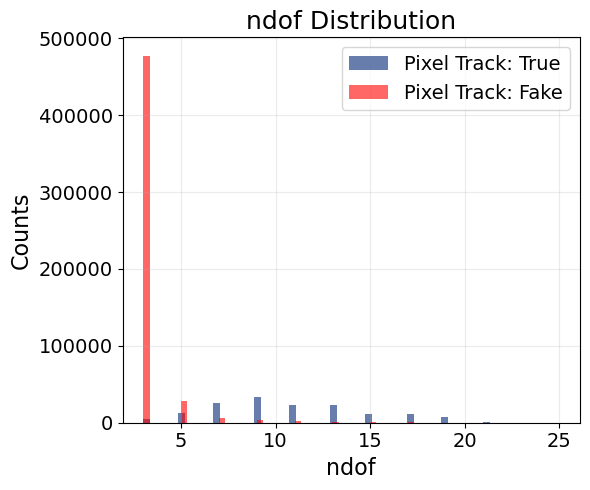

In [14]:
fname = "hltPixelTrack_ndof"
i = recoPixelTrackFeatures_names.index(fname)

plot.plot_single_feature(
    X_ref=recoPixelTrackFeatures,
    feature_index=i,
    feature_name=fname,
    y=recoPixelTrackLabels,
    density=False,
    figsize=(6, 5),
    labels=("Pixel Track", ""),
    title="ndof Distribution",
    xlabel="ndof"
)

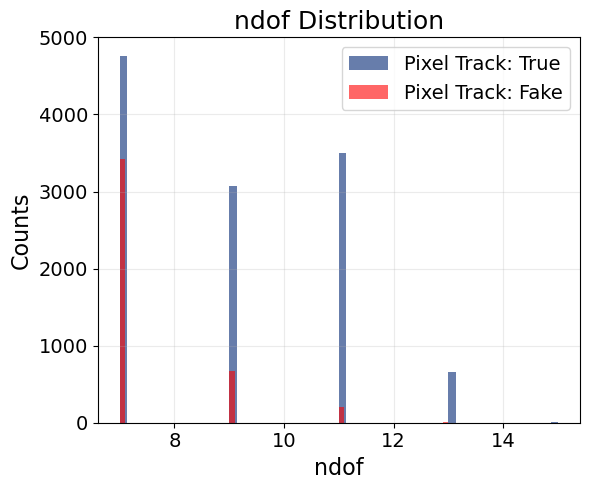

In [10]:
fname = "hltPixelTrack_ndof"
i = recoPixelTrackFeatures_names.index(fname)

mask_plot = (npixel_hits==6)
plot.plot_single_feature(
    X_ref=recoPixelTrackFeatures[mask_plot,...],
    feature_index=i,
    feature_name=fname,
    y=recoPixelTrackLabels[mask_plot],
    density=False,
    figsize=(6, 5),
    labels=("Pixel Track", ""),
    title="ndof Distribution",
    xlabel="ndof"
)

In [11]:
mask_chi2_5 = (chi2_over_ndof > 5)
mask_chi2_7 = (chi2_over_ndof > 7)

true_hits  = recoPixelTrackLabels[mask_hits].sum()
true_chi_5 = recoPixelTrackLabels[mask_chi2_5].sum()
true_chi_7 = recoPixelTrackLabels[mask_chi2_7].sum()

fake_hits = recoPixelTrackLabels[mask_hits].shape[0] - true_hits
fake_chi_5 = recoPixelTrackLabels[mask_chi2_5].shape[0] - true_chi_5
fake_chi_7 = recoPixelTrackLabels[mask_chi2_7].shape[0] - true_chi_7

print("True tracks: ", true_hits, true_chi_5, true_chi_7) 
print("Fake tracks: ", fake_hits, fake_chi_5, fake_chi_7) 

True tracks:  509 1658 702
Fake tracks:  242850.0 228527.0 126483.0


In [12]:
print("recHitFeatures: ", recHitFeatures.shape)
print("recoPixelTrackFeatures: ", recoPixelTrackFeatures.shape)
print("isRecHit: ", isRecHit.shape)

recHitFeatures:  (676838, 16, 9)
recoPixelTrackFeatures:  (676838, 25)
isRecHit:  (676838, 16)


In [13]:
N = recoPixelTrackLabels.shape[0]
N_true = recoPixelTrackLabels.sum()
N_fake = N - N_true

w_true = N / (2 * N_true)
w_fake = N / (2 * N_fake)

print(w_true, w_fake)
print(recoPixelTrackLabels.sum()/recoPixelTrackLabels.shape[0])

2.1799448602826557 0.6488144080859516
0.22936359956149036


## Preprocessing

### RecoPixelTracks

Inspect the properties of recoPixelTrack features to look for potential problems

In [ ]:
# Compute feature statistics
summary = summ.summarize_features(recoPixelTrackFeatures, recoPixelTrackFeatures_names)
summary_df = summ.print_summary_table(summary, sort_by="skew", top=15)
issues = summ.flag_outliers(summary)

In [ ]:
plot.plot_feature_distributions(
    X_ref=recoPixelTrackFeatures,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    density=True,
    labels=("Original recoTrack Features",)
)

In [ ]:
plot.plot_feature_distributions(
    X_ref=recoPixelTrackFeatures[mask_hits,:],
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels[mask_hits],
    labels=("recoTrack npixelhits=2",)
)

Apply clipping and log transformation where needed 

In [ ]:
do_log_track = []
# Variables to log-transform and clip
log_vars = ["hltPixelTrack_pt", "hltPixelTrack_ptErr", 
            "hltPixelTrack_dxyError", "hltPixelTrack_phiErr", 
            "hltPixelTrack_chi2", "hltPixelTrack_dszErr",
            "hltPixelTrack_dZError", "hltPixelTrack_qoverpErr", "hltPixelTrack_lambdaErr", "hltPixelTrack_etaErr"]

recoPixelTrackFeatures_proc = recoPixelTrackFeatures.copy()
for i, name in enumerate(recoPixelTrackFeatures_names):
    do_log_track.append(name in log_vars)
    if name in log_vars:
        x = recoPixelTrackFeatures_proc[:, i]
        x = np.log10(EPSILON+x)
        recoPixelTrackFeatures_proc[:, i] = x


In [ ]:
plot.plot_feature_distributions(
    X_ref=recoPixelTrackFeatures_proc,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Preprocessed recoTrack Features",)
)

In [ ]:
clip_min_track = []
clip_max_track = []
# Variables to just clip
clip_vars = [
    "hltPixelTrack_pt", "hltPixelTrack_ptErr", 
    "hltPixelTrack_dxyError", "hltPixelTrack_phiErr", 
    "hltPixelTrack_chi2", "hltPixelTrack_dszErr",
    "hltPixelTrack_dZError", "hltPixelTrack_qoverpErr", "hltPixelTrack_lambdaErr", "hltPixelTrack_etaErr",
    "hltPixelTrack_dXY", "hltPixelTrack_dsz", 
    "hltPixelTrack_vx", "hltPixelTrack_vy"]

for i, name in enumerate(recoPixelTrackFeatures_names):
    if name in clip_vars:
        x = recoPixelTrackFeatures_proc[:, i]
        x, lo, hi = pre.clip_outliers(x, low=LOW_PERCENTILE, high=HIGH_PERCENTILE)
        recoPixelTrackFeatures_proc[:, i] = x
        clip_min_track.append(lo)
        clip_max_track.append(hi)
    else:
        clip_min_track.append(np.nan)
        clip_max_track.append(np.nan)

In [ ]:
plot.plot_feature_distributions(
    X_ref=recoPixelTrackFeatures_proc,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Preprocessed recoTrack Features",)
)

Apply normalization

In [ ]:
recoPixelTrackFeaturesNorm, recoPixelTrack_mean, recoPixelTrack_std = pre.normalize_2d(recoPixelTrackFeatures_proc)

In [ ]:
plot.plot_feature_distributions(
    X_ref=recoPixelTrackFeaturesNorm,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Normalized recoTrack Features",)
)

In [ ]:
fname = "hltPixelTrack_dZError"
i = recoPixelTrackFeatures_names.index(fname)

plot.plot_single_feature(
    X_ref=recoPixelTrackFeaturesNorm,
    feature_index=i,
    feature_name=fname,
    y=recoPixelTrackLabels,
    figsize=(6, 5),
     labels=("Pixel Track", ""),
    title="HLT Pixel Track dZ Error Distribution",
    xlabel="dZ Error"
)

In [ ]:
summary_norm = summ.summarize_features(recoPixelTrackFeaturesNorm, recoPixelTrackFeatures_names)
summary_norm_df = summ.print_summary_table(summary_norm, sort_by="skew", top=15)
issues = summ.flag_outliers(summary_norm)

### RecHits

In [ ]:
summary_recHits = summ.summarize_recHits(recHitFeatures, isRecHit, recHitBranches)
summary_recHits_df = summ.print_summary_table(summary_recHits, sort_by="skew", top=15)
issues_recHits = summ.flag_outliers(summary_recHits)

In [ ]:
recHitFeatures_flat = np.array(pre.masked_flatten(recHitFeatures, isRecHit)).T

# Optional: if you want to color by track label (e.g. true/fake track)
y_hits = np.repeat(recoPixelTrackLabels, isRecHit.sum(axis=1))  # only if you want to compare by label

plot.plot_feature_distributions(
    X_ref=recHitFeatures_flat,
    feature_names=recHitBranches,
    y=y_hits,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

In [ ]:
fname = "hltPixelTrackRecHits_globalR"
i = recHitBranches.index(fname)

plot.plot_single_feature(
    X_ref=recHitFeatures_flat,
    feature_index=i,
    feature_name=fname,
    y=y_hits,
    density=True,
    figsize=(6, 5),
     labels=("Hits", ""),
    title="Rec Hit R Distribution",
    xlabel="R"
)

In [ ]:
do_log_hit = []
log_recHit_vars = ["hltPixelTrackRecHits_globalR", "hltPixelTrackRecHits_globalErrX", "hltPixelTrackRecHits_globalErrY", "hltPixelTrackRecHits_globalErrZ"]
       
recHitFeatures_proc = recHitFeatures.copy()
for f, name in enumerate(recHitBranches):
    do_log_hit.append(name in log_recHit_vars)
    if name in log_recHit_vars:
        print(f, name)
        recHitFeatures_proc = pre.masked_log_transform(recHitFeatures_proc, isRecHit, f, eps=EPSILON, method='log_eps')

In [ ]:
recHitFeatures_proc_plot = np.array(pre.masked_flatten(recHitFeatures_proc, isRecHit)).T

plot.plot_feature_distributions(
    X_ref=recHitFeatures_proc_plot,
    feature_names=recHitBranches,
    y=y_hits,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

In [ ]:
recHitFeatures_norm, recHit_mean, recHit_std = pre.normalize_features_masked(recHitFeatures_proc, isRecHit, eps=EPSILON)

recHitFeatures_norm_plot = np.array(pre.masked_flatten(recHitFeatures_norm, isRecHit)).T

plot.plot_feature_distributions(
    X_ref=recHitFeatures_norm_plot,
    feature_names=recHitBranches,
    y=y_hits,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

In [ ]:
clip_min_hit = [np.nan for i in enumerate(recHitBranches)]
clip_max_hit = [np.nan for i in enumerate(recHitBranches)]

## Data saving

In [ ]:
save_dict = {
    # --- Core datasets ---
    "recHitFeatures": torch.tensor(recHitFeatures_norm, dtype=torch.float32),
    "isRecHit": torch.tensor(isRecHit, dtype=torch.bool),
    "recoPixelTrackFeatures": torch.tensor(recoPixelTrackFeaturesNorm, dtype=torch.float32),
    "labels": torch.tensor(recoPixelTrackLabels, dtype=torch.float32),
    "isHighPurity": torch.tensor(recoPixelTrackIsHighPurity, dtype=torch.bool),

    # --- Normalization stats ---
    "recHit_mean": torch.tensor(recHit_mean, dtype=torch.float32),
    "recHit_std": torch.tensor(recHit_std, dtype=torch.float32),
    "recoPixelTrack_mean": torch.tensor(recoPixelTrack_mean, dtype=torch.float32),
    "recoPixelTrack_std": torch.tensor(recoPixelTrack_std, dtype=torch.float32),
    
    # --- Metadata ---
    "recHitBranches": recHitBranches,
    "recoPixelTrackBranches": recoPixelTrackBranches[2:],  # exclude label and isHP
    "MAX_HITS": MAX_HITS,
    "EPSILON": EPSILON,
    "LOW_PERCENTILE": LOW_PERCENTILE,
    "HIGH_PERCENTILE": HIGH_PERCENTILE,
    "log_vars": log_vars,
    "clip_vars": clip_vars,
    "log_recHit_vars": log_recHit_vars,
    "do_log_hit": torch.tensor(do_log_hit, dtype=torch.bool),
    "clip_min_hit": torch.tensor(clip_min_hit, dtype=torch.float32),
    "clip_max_hit": torch.tensor(clip_max_hit, dtype=torch.float32),
    "do_log_track": torch.tensor(do_log_track, dtype=torch.bool),
    "clip_min_track": torch.tensor(clip_min_track, dtype=torch.float32),
    "clip_max_track": torch.tensor(clip_max_track, dtype=torch.float32)
}

torch.save(save_dict, OUTPUT_PATH)
print(f"✅ Saved preprocessed dataset and parameters to {OUTPUT_PATH}")

In [ ]:
val_fraction = 0.2
dataset_len = len(save_dict["labels"])
val_len = int(dataset_len * val_fraction)
train_len = dataset_len - val_len

indices = torch.randperm(dataset_len, generator=torch.Generator().manual_seed(42))
train_idx, val_idx = indices[:train_len], indices[train_len:]

def subset_dict(save_dict, indices):
    subset = {}
    # Only split the core dataset tensors
    for key in ["recHitFeatures", "isRecHit", "recoPixelTrackFeatures", "labels", "isHighPurity"]:
        subset[key] = save_dict[key][indices]
    
    # Copy metadata and normalization stats as-is
    for key in ["recHit_mean", "recHit_std", "recoPixelTrack_mean", "recoPixelTrack_std",
                "recHitBranches", "recoPixelTrackBranches", "MAX_HITS", "EPSILON",
                "LOW_PERCENTILE", "HIGH_PERCENTILE", "log_vars", "clip_vars", "log_recHit_vars", 
                "do_log_hit", "clip_min_hit", "clip_max_hit","do_log_track", "clip_min_track", "clip_max_track"]:
        subset[key] = save_dict[key]
    
    return subset

train_dict = subset_dict(save_dict, train_idx)
val_dict = subset_dict(save_dict, val_idx)

torch.save(train_dict, OUTPUT_PATH_TRAIN)
torch.save(val_dict, OUTPUT_PATH_VAL)
print(f"✅ Saved train and validation datasets with metadata")


## Post-Processing 

In [1]:
import torch
import copy

# ------------------------------------------------------------------
# Paths
# ------------------------------------------------------------------
base = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data"

train_in = f"{base}/100_tracks_train_dataset_skip-connections.pt"
val_in   = f"{base}/100_tracks_val_dataset_skip-connections.pt"

train_out = f"{base}/100_tracks_train_dataset_skip-connections_noHitPattern.pt"
val_out   = f"{base}/100_tracks_val_dataset_skip-connections_noHitPattern.pt"

# Features to remove
features_to_remove = [
    "hltPixelTrack_nPixelHits",
    "hltPixelTrack_nTrkLays",
]

# ------------------------------------------------------------------
def remove_features(dataset, features_to_remove):
    dataset = copy.deepcopy(dataset)

    branches = list(dataset["recoPixelTrackBranches"])

    # indices to keep
    keep_idx = [i for i, b in enumerate(branches) if b not in features_to_remove]

    # --- core tensors ---
    dataset["recoPixelTrackFeatures"] = dataset["recoPixelTrackFeatures"][:, keep_idx]    
    dataset["recoPixelTrack_mean"]    = dataset["recoPixelTrack_mean"][0,keep_idx]
    dataset["recoPixelTrack_std"]     = dataset["recoPixelTrack_std"][0,keep_idx]

    # --- metadata ---
    dataset["recoPixelTrackBranches"] = [branches[i] for i in keep_idx]

    # --- preprocessing masks ---
    dataset["do_log_track"]  = dataset["do_log_track"][keep_idx]
    dataset["clip_min_track"] = dataset["clip_min_track"][keep_idx]
    dataset["clip_max_track"] = dataset["clip_max_track"][keep_idx]

    return dataset

# ------------------------------------------------------------------
# Load datasets
# ------------------------------------------------------------------
train_dict = torch.load(train_in, map_location="cpu")
val_dict   = torch.load(val_in, map_location="cpu")

# ------------------------------------------------------------------
# Remove features
# ------------------------------------------------------------------
train_dict_new = remove_features(train_dict, features_to_remove)
val_dict_new   = remove_features(val_dict, features_to_remove)

# ------------------------------------------------------------------
# Save new datasets
# ------------------------------------------------------------------
torch.save(train_dict_new, train_out)
torch.save(val_dict_new, val_out)

print("✅ Saved datasets without:")
for f in features_to_remove:
    print("   -", f)

print("Train features:", len(train_dict_new["recoPixelTrackBranches"]))
print("Val   features:", len(val_dict_new["recoPixelTrackBranches"]))

✅ Saved datasets without:
   - hltPixelTrack_nPixelHits
   - hltPixelTrack_nTrkLays
Train features: 23
Val   features: 23
